# **IOSRCRVD: Implementación ACO y validación exacta (integrado vs two-stage) en instancias de referencia**

Este cuaderno presenta la implementación computacional y la validación experimental del modelo Integrated Optimal Scheduling of Repair Crew and Relief Vehicle after Disaster (IOSRCRVD). A partir de la formulación matemática desarrollada previamente, se implementan distintos enfoques algorítmicos que permiten simular el comportamiento dinámico del sistema, reproducir los resultados del artículo de referencia y comparar explícitamente la planificación integrada frente a enfoques secuenciales tradicionales. El objetivo principal es analizar el impacto de la coordinación entre las decisiones de reparación y distribución sobre el tiempo total de respuesta ante un desastre.

## **Introducción**
El problema IOSRCRVD aborda la planificación conjunta de la reparación de infraestructuras críticas y la distribución de ayuda humanitaria en una red de transporte afectada por un desastre. A diferencia de los enfoques clásicos, el modelo considera explícitamente la interacción temporal entre ambos procesos, de modo que la accesibilidad de las zonas afectadas depende de la secuencia y el momento en que se realizan las reparaciones.

El presente cuaderno no tiene como objetivo reformular el modelo matemático, sino operacionalizarlo mediante herramientas computacionales. En particular, se persiguen los siguientes objetivos: (i) implementar la lógica de accesibilidad y esperas implícita en el modelo, (ii) reproducir el ejemplo numérico presentado en el artículo, (iii) comparar soluciones obtenidas mediante planificación integrada y secuencial, y (iv) proporcionar resultados reproducibles y analizables mediante tablas y representaciones gráficas.

## **Configuración del entorno y reproducibilidad**
Esta sección inicializa el entorno computacional y garantiza la reproducibilidad de los experimentos, aspecto fundamental en la investigación operativa. El uso de una semilla fija permite comparar resultados entre ejecuciones y analizar el comportamiento del algoritmo heurístico de manera controlada.

In [1]:
import math, random, heapq
from dataclasses import dataclass
from typing import Dict, List, Tuple, Set
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import itertools

SEED = 7
random.seed(SEED)
np.random.seed(SEED)

OUT = Path("outputs")
(OUT / "figures").mkdir(parents=True, exist_ok=True)
(OUT / "tables").mkdir(parents=True, exist_ok=True)

Node = int

## **Modelo de datos**
El escenario se modela como un grafo no dirigido en el que los arcos representan tiempos de viaje. A partir de este grafo se distinguen dos subconjuntos de nodos:

- **Nodos de reparación**, que deben ser intervenidos antes de poder ser utilizados sin restricciones.
- **Nodos de demanda**, que requieren la prestación de un servicio con una duración determinada.

Cada nodo de reparación tiene asociado un tiempo de reparación, mientras que cada nodo de demanda tiene un tiempo de servicio. Ambos procesos parten de un mismo depósito inicial.

Toda esta información se encapsula en una única estructura de datos, lo que facilita la definición de distintos escenarios de prueba sin alterar el algoritmo.

### **Estructuras de datos del problema**
Siguiendo la formulación matemática del IOSRCRVD, se definen estructuras de datos que representan los parámetros del modelo, así como la solución generada por el algoritmo. Estas estructuras corresponden directamente a los conjuntos $V_r$ y $V_d$, y a los parámetros $t_{ij}$, $s_i$, $s_i'$, así como a la variable objetivo $f'$.

In [2]:
@dataclass
class ProblemData:
    adj: Dict[Node, List[Tuple[Node, float]]]   # t_ij: Red transformada del artículo
    depot: Node                                # nodo 0
    repair_nodes: Set[Node]                    # V_r
    demand_nodes: Set[Node]                    # V_d
    repair_time: Dict[Node, float]             # s_i
    demand_service_time: Dict[Node, float]     # s'_i

### **Representación de la solución**
La solución computacional recoge explícitamente las decisiones equivalentes a las variables de decisión del modelo: el orden de reparación, el orden de reparto y los tiempos de finalización. De este modo, la implementación mantiene la trazabilidad con la formulación matemática.

In [3]:
@dataclass
class Solution:
    repair_route: List[Node]                  # secuencia tipo x_ij
    relief_route: List[Node]                  # secuencia tipo z_ij
    repair_done_time: Dict[Node, float]       # d_i
    objective: float                          # f'

### **Parámetros ACO**
El artículo introduce un algoritmo ACO para superar la intractabilidad del MILP en instancias grandes, empleando una regla probabilística basada en feromonas y heurística, y un mecanismo de evaporación/refuerzo para guiar la búsqueda. En este notebook, los parámetros ACOParams controlan el equilibrio exploración/explotación del algoritmo ACO: $\alpha$ pondera feromonas, $\beta$ pondera heurística (coste), $\rho$ evapora memoria histórica y $Q$ regula refuerzo. Esta parametrización es estándar en ACO y permite aproximar soluciones integradas de forma eficiente.

In [4]:
@dataclass
class ACOParams:
    alpha: float = 1.0
    beta: float = 2.0
    rho: float = 0.2
    Q: float = 1.0
    num_ants: int = 60
    num_iters: int = 300
    seed: int = SEED

## **Representación computacional de la red y de los parámetros del modelo**
La red de transporte se modela como un grafo no dirigido transformado, siguiendo el enfoque propuesto en el artículo IOSRCRVD. En esta transformación, las carreteras dañadas se representan mediante nodos de reparación insertados entre los extremos de los arcos originales, mientras que las poblaciones afectadas se modelan como nodos de demanda. El nodo depósito representa el origen tanto del equipo de reparación como del vehículo de ayuda.

Esta representación resulta fundamental para capturar las dependencias temporales del problema, ya que permite expresar de forma explícita que el paso por determinadas infraestructuras está condicionado a su reparación previa. De este modo, la estructura topológica del grafo refleja directamente las restricciones operativas del sistema post-desastre.

In [5]:
def add_undirected_edge(adj: Dict[Node, List[Tuple[Node, float]]], u: Node, v: Node, w: float):
    # Asegura que u exista en el diccionario y agrega vecino v con peso w
    adj.setdefault(u, []).append((v, w))
    # Como es no dirigido, también agrega u como vecino de v con el mismo peso
    adj.setdefault(v, []).append((u, w))

In [6]:
def shortest_path_nodes(data: ProblemData, s: int, t: int):
    G = to_nx_graph(data)
    return nx.shortest_path(G, s, t, weight="weight")

def shortest_path_time(data: ProblemData, s: int, t: int):
    G = to_nx_graph(data)
    return nx.shortest_path_length(G, s, t, weight="weight")

In [7]:
def to_nx_graph(data: ProblemData) -> nx.Graph:
    G = nx.Graph()
    for u, neighs in data.adj.items():
        for v, w in neighs:
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=w)
    return G

In [8]:
def draw_graph(data: ProblemData, title: str, pos=None, savepath=None):
    G = to_nx_graph(data)
    if pos is None:
        pos = nx.spring_layout(G, seed=SEED)

    depot = {data.depot}
    repairs = set(data.repair_nodes)
    demands = set(data.demand_nodes)
    transit = set(G.nodes()) - depot - repairs - demands

    plt.figure(figsize=(8, 5))
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_nodes(G, pos, nodelist=list(transit), node_color="lightgray", label="Tránsito")
    nx.draw_networkx_nodes(G, pos, nodelist=list(repairs), node_color="orange", label="Reparación")
    nx.draw_networkx_nodes(G, pos, nodelist=list(demands), node_color="red", label="Demanda")
    nx.draw_networkx_nodes(G, pos, nodelist=list(depot), node_color="green", label="Depósito")
    nx.draw_networkx_labels(G, pos)
    plt.legend()
    plt.title(title)
    plt.axis("off")
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()
    return pos

## **Cálculo de distancias y tiempos de viaje**
El modelo requiere evaluar repetidamente los tiempos de desplazamiento entre nodos de la red. Para ello, se emplean caminos mínimos sobre el grafo transformado, que proporcionan los tiempos de viaje estáticos entre pares de nodos en ausencia de esperas. Estos tiempos se utilizan tanto en la construcción de soluciones heurísticas como en la evaluación de cronologías temporales.

El uso de distancias mínimas permite desacoplar el cálculo de rutas del tratamiento de las reparaciones, que se gestiona posteriormente mediante restricciones temporales. Esta separación resulta coherente con la formulación matemática del artículo, en la que los tiempos de viaje y los tiempos de reparación aparecen como parámetros independientes.

In [9]:
def dijkstra_static(adj: Dict[Node, List[Tuple[Node, float]]], source: Node) -> Dict[Node, float]:
    dist: Dict[Node, float] = {source: 0.0}      # Distancia mínima conocida al inicio: source = 0
    pq = [(0.0, source)]                         # Cola de prioridad: (distancia, nodo)

    while pq:
        d, u = heapq.heappop(pq)                 # Toma el nodo con menor distancia actual

        # Si este estado (d,u) está "desactualizado", lo ignoramos
        if d != dist.get(u, math.inf):
            continue

        # Relaja aristas: intenta mejorar distancias a vecinos
        for v, w in adj.get(u, []):
            nd = d + w                           # Nueva distancia candidata a v pasando por u
            if nd < dist.get(v, math.inf):       # Si mejora, se actualiza
                dist[v] = nd
                heapq.heappush(pq, (nd, v))      # Se mete a la cola para seguir expandiendo

    return dist                                  # Distancia mínima desde source a cada nodo alcanzable

## **Accesibilidad temporal y esperas: Llegada más temprana con reparación**
Un elemento clave del modelo IOSRCRVD es la noción de accesibilidad temporal. Un nodo de demanda puede ser topológicamente alcanzable desde el depósito, pero no necesariamente accesible en un instante dado si el camino hacia él atraviesa infraestructuras aún no reparadas. En tal caso, el vehículo de ayuda debe esperar hasta que la reparación correspondiente haya finalizado.

Desde el punto de vista computacional, esta lógica se implementa permitiendo esperas dinámicas cuando el vehículo alcanza un nodo de reparación antes de su tiempo de finalización. Este mecanismo reproduce el comportamiento implícito en las restricciones de precedencia temporal del modelo matemático y resulta esencial para evaluar correctamente el instante real de llegada y servicio en cada nodo de demanda.

In [10]:
def earliest_arrival_dijkstra(
    adj: Dict[Node, List[Tuple[Node, float]]],
    source: Node,
    start_time: float,
    repair_done: Dict[Node, float],
    repair_nodes: Set[Node],
) -> Dict[Node, float]:
    dist: Dict[Node, float] = {source: start_time}
    pq = [(start_time, source)]

    def wait_if_needed(node: Node, t: float) -> float:
        if node in repair_nodes:
            return max(t, repair_done.get(node, 0.0))
        return t

    dist[source] = wait_if_needed(source, dist[source])

    while pq:
        t_u, u = heapq.heappop(pq)
        if t_u != dist.get(u, math.inf):
            continue
        for v, w in adj.get(u, []):
            t_v = wait_if_needed(v, t_u + w)
            if t_v < dist.get(v, math.inf):
                dist[v] = t_v
                heapq.heappush(pq, (t_v, v))
    return dist

In [11]:
def earliest_arrival_dijkstra(
    adj: Dict[Node, List[Tuple[Node, float]]],
    source: Node,
    start_time: float,           # Tiempo real de inicio
    repair_done: Dict[Node, float],  # Para cada nodo reparable: momento en que queda reparado
    repair_nodes: Set[Node],         # Conjunto de nodos que requieren reparación
) -> Dict[Node, float]:

    dist: Dict[Node, float] = {source: start_time}   # dist guarda "tiempo de llegada más temprano"
    pq = [(start_time, source)]                      # Cola: (tiempo_llegada, nodo)

    # Función auxiliar: si el nodo está en reparación, obliga a esperar hasta repair_done[node]
    def wait_if_needed(node: Node, t: float) -> float:
        if node in repair_nodes:
            return max(t, repair_done.get(node, 0.0))  # si llegas antes, esperas; si llegas después, sigues
        return t                                       # si no requiere reparación, no hay espera

    # Ajusta el tiempo en el source por si el source también requiere reparación
    dist[source] = wait_if_needed(source, dist[source])

    while pq:
        t_u, u = heapq.heappop(pq)                    # Expande el nodo con menor tiempo de llegada

        # Ignora estados viejos (ya hay un mejor tiempo guardado en dist)
        if t_u != dist.get(u, math.inf):
            continue

        # Explora vecinos como en Dijkstra, pero ahora trabajamos con tiempos (t) no solo distancias
        for v, w in adj.get(u, []):
            # Tiempo de llegada a v: tiempo actual + viaje, y luego posible espera si v no está reparado
            t_v = wait_if_needed(v, t_u + w)

            # Relajación: si encontramos llegada más temprana, actualizamos
            if t_v < dist.get(v, math.inf):
                dist[v] = t_v
                heapq.heappush(pq, (t_v, v))

    return dist  # Devuelve el tiempo más temprano en que puedes llegar a cada nodo (respetando reparaciones)

## **Enfoque heurístico: Ant Colony Optimization (ACO)**
El problema IOSRCRVD pertenece a la clase de problemas NP-difíciles, al combinar decisiones de ruteo, secuenciación y programación temporal. En este contexto, los métodos exactos resultan inviables para instancias de tamaño medio o grande, lo que justifica el uso de enfoques heurísticos y metaheurísticos.

El algoritmo de colonia de hormigas (ACO) se adapta de forma natural a este tipo de problemas, ya que permite construir soluciones de ruteo de manera iterativa, incorporar información heurística basada en tiempos de viaje y refinar progresivamente la calidad de las soluciones mediante aprendizaje colectivo.

### **Construcción de soluciones con ACO**
En el enfoque ACO implementado, cada solución se construye en dos fases. En primer lugar, se genera una ruta para el equipo de reparación, determinando el orden en el que se reparan las infraestructuras críticas. A partir de esta secuencia se calculan los tiempos de finalización de cada reparación.

En una segunda fase, se construye la ruta del vehículo de ayuda teniendo en cuenta dichos tiempos de reparación. El vehículo puede desplazarse por la red, pero su llegada efectiva a ciertos nodos puede verse retrasada por esperas asociadas a reparaciones no finalizadas. De este modo, la construcción de la solución refleja la planificación integrada propuesta en el artículo.

In [12]:
def roulette_choice(cands: List[Node], weights: List[float]) -> Node:
    s = sum(weights)
    if s <= 0:
        return random.choice(cands)
    r = random.random() * s
    acc = 0.0
    for c, w in zip(cands, weights):
        acc += w
        if acc >= r:
            return c
    return cands[-1]

In [13]:
class IOSRCRVD_ACO:
    def __init__(self, data: ProblemData, p: ACOParams):
        self.data = data
        self.p = p
        random.seed(p.seed)

        self.tau_rep: Dict[Tuple[Node, Node], float] = {}
        self.tau_dem: Dict[Tuple[Node, Node], float] = {}
        self.static_dist_cache: Dict[Node, Dict[Node, float]] = {}

        self._init_pheromones()

    def _init_pheromones(self):
        init = 1.0
        rep_nodes = self.data.repair_nodes | {self.data.depot}
        dem_nodes = self.data.demand_nodes | {self.data.depot}

        for i in rep_nodes:
            for j in rep_nodes:
                if i != j:
                    self.tau_rep[(i, j)] = init

        for i in dem_nodes:
            for j in dem_nodes:
                if i != j:
                    self.tau_dem[(i, j)] = init

    def _heur(self, cost: float) -> float:
        return 1.0 / max(cost, 1e-6)

    def _static_dist(self, src: Node) -> Dict[Node, float]:
        if src not in self.static_dist_cache:
            self.static_dist_cache[src] = dijkstra_static(self.data.adj, src)
        return self.static_dist_cache[src]

    # Repair Crew
    def build_repair(self) -> Tuple[List[Node], Dict[Node, float]]:
        route = [self.data.depot]
        remaining = set(self.data.repair_nodes)

        t = 0.0
        current = self.data.depot
        done: Dict[Node, float] = {}

        while remaining:
            dist = self._static_dist(current)
            cands = [v for v in remaining if v in dist and math.isfinite(dist[v])]
            if not cands:
                return route, {v: math.inf for v in self.data.repair_nodes}

            weights = []
            for v in cands:
                weights.append(
                    (self.tau_rep.get((current, v), 1.0) ** self.p.alpha) *
                    (self._heur(dist[v]) ** self.p.beta)
                )

            nxt = roulette_choice(cands, weights)

            t += dist[nxt]
            t += self.data.repair_time.get(nxt, 0.0)
            done[nxt] = t

            route.append(nxt)
            remaining.remove(nxt)
            current = nxt

        return route, done

    # Relief vehicle
    def build_relief(self, repair_done: Dict[Node, float]) -> Tuple[List[Node], float]:
        route = [self.data.depot]
        remaining = set(self.data.demand_nodes)

        t = 0.0
        current = self.data.depot
        last_finish = 0.0

        while remaining:
            dist = earliest_arrival_dijkstra(
                self.data.adj, current, t, repair_done, self.data.repair_nodes
            )
            cands = [v for v in remaining if v in dist and math.isfinite(dist[v])]
            if not cands:
                return route, math.inf

            weights = []
            for v in cands:
                travel_effective = max(dist[v] - t, 0.0)
                weights.append(
                    (self.tau_dem.get((current, v), 1.0) ** self.p.alpha) *
                    (self._heur(travel_effective) ** self.p.beta)
                )

            nxt = roulette_choice(cands, weights)

            t = dist[nxt] + self.data.demand_service_time.get(nxt, 0.0)
            last_finish = t

            route.append(nxt)
            remaining.remove(nxt)
            current = nxt

        return route, last_finish

    # Pheromones
    def evaporate(self):
        for k in list(self.tau_rep.keys()):
            self.tau_rep[k] *= (1.0 - self.p.rho)
        for k in list(self.tau_dem.keys()):
            self.tau_dem[k] *= (1.0 - self.p.rho)

    def reinforce(self, sol: Solution):
        if not math.isfinite(sol.objective) or sol.objective <= 0:
            return
        delta = self.p.Q / sol.objective

        for i in range(len(sol.repair_route) - 1):
            a, b = sol.repair_route[i], sol.repair_route[i + 1]
            self.tau_rep[(a, b)] = self.tau_rep.get((a, b), 0.0) + delta

        for i in range(len(sol.relief_route) - 1):
            a, b = sol.relief_route[i], sol.relief_route[i + 1]
            self.tau_dem[(a, b)] = self.tau_dem.get((a, b), 0.0) + delta

    # Solve
    def solve(self) -> Solution:
        best = Solution([], [], {}, math.inf)

        for _ in range(self.p.num_iters):
            iter_best = Solution([], [], {}, math.inf)

            for _k in range(self.p.num_ants):
                rep_route, rep_done = self.build_repair()
                rel_route, obj = self.build_relief(rep_done)
                sol = Solution(rep_route, rel_route, rep_done, obj)

                if sol.objective < iter_best.objective:
                    iter_best = sol

            self.evaporate()
            self.reinforce(iter_best)

            if iter_best.objective < best.objective:
                best = iter_best

        return best

Cada solución generada se evalúa simulando explícitamente la evolución temporal del sistema. En particular, se calcula el instante en que el vehículo de ayuda completa el suministro en el último nodo de demanda, que constituye el valor de la función objetivo $f'$. Este criterio coincide con el objetivo del modelo matemático, que busca minimizar el tiempo total de respuesta del sistema. La evaluación explícita de la cronología permite comparar soluciones de forma precisa y coherente con la formulación teórica.

## **Trazabilidad y análisis de resultados**
Con el fin de facilitar el análisis de las soluciones obtenidas, se reconstruye la traza temporal completa del proceso de distribución de ayuda. Esta traza incluye los instantes de salida, llegada, inicio y finalización del servicio en cada nodo de demanda.

La generación de tablas de resultados permite analizar de forma detallada el impacto de las decisiones de reparación sobre la distribución, así como comparar diferentes enfoques de planificación. Estas tablas constituyen una herramienta fundamental tanto para la validación del modelo como para la discusión de resultados.

In [14]:
def trace_relief(data: ProblemData, sol: Solution):
    t = 0.0
    current = data.depot
    rows = []

    for nxt in sol.relief_route[1:]:
        dist = earliest_arrival_dijkstra(data.adj, current, t, sol.repair_done_time, data.repair_nodes)
        arrival = dist[nxt]
        service = data.demand_service_time.get(nxt, 0.0)
        finish = arrival + service

        rows.append((current, nxt, t, arrival, service, finish))

        t = finish
        current = nxt

    return rows

In [15]:
def results_tables(data: ProblemData, sol: Solution):
    df_rep = pd.DataFrame(
        [{"repair_node": i, "repair_finish": sol.repair_done_time[i]}
        for i in sol.repair_done_time]
    )
    df_rel = pd.DataFrame(
        trace_relief(data, sol),
        columns=["from", "to", "t_depart", "t_arrive", "service", "t_finish"]
    )
    return df_rep, df_rel

## **Solución secuencial en dos etapas (Two-Stage Approach)**
En el enfoque secuencial, el problema se descompone en dos etapas. En la primera, se determina una secuencia de reparación sin considerar explícitamente la distribución de ayuda. En la segunda, se planifica la ruta del vehículo de ayuda suponiendo que las reparaciones se realizan según la secuencia fijada previamente.

Este enfoque reproduce el tipo de planificación tradicional analizado en el artículo como referencia. Aunque resulta conceptualmente más sencillo, no tiene en cuenta la interacción completa entre reparaciones y distribución, lo que puede conducir a soluciones subóptimas en términos del tiempo total de respuesta.

In [16]:
def repair_done_times_from_order(data: ProblemData, repair_order):
    done = {}
    t = 0.0
    cur = data.depot
    for j in repair_order:
        t += shortest_path_time(data, cur, j)
        t += float(data.repair_time[j])
        done[j] = t
        cur = j
    return done

In [17]:
def objective_fprime_for_demand_order(data: ProblemData, demand_order, repair_done):
    t = 0.0
    cur = data.depot
    for nxt in demand_order:
        dist = earliest_arrival_dijkstra(data.adj, cur, t, repair_done, data.repair_nodes)
        if nxt not in dist or not math.isfinite(dist[nxt]):
            return math.inf
        arrival = dist[nxt]
        t = arrival + float(data.demand_service_time[nxt])
        cur = nxt
    return t

In [19]:
def solve_integrated_exact(data: ProblemData):
    """
    SOLUCIÓN INTEGRADA EXACTA:
    minimiza f' sobre todas las combinaciones (orden reparaciones, orden demandas).
    """
    best = {"fprime": math.inf, "rep": None, "dem": None, "d": None}
    for rep_order in itertools.permutations(sorted(data.repair_nodes)):
        d = repair_done_times_from_order(data, rep_order)
        for dem_order in itertools.permutations(sorted(data.demand_nodes)):
            fprime = objective_fprime_for_demand_order(data, dem_order, d)
            if fprime < best["fprime"]:
                best = {"fprime": fprime, "rep": rep_order, "dem": dem_order, "d": d}
    return best

## **Solución integrada IOSRCRVD**
En la planificación integrada, las decisiones de reparación y distribución se coordinan desde el inicio. La secuencia de reparaciones se elige teniendo en cuenta su impacto directo sobre la accesibilidad de los nodos de demanda y sobre la cronología del vehículo de ayuda.

Este enfoque permite obtener soluciones en las que el vehículo de ayuda completa su misión antes, aun cuando algunas reparaciones se finalicen más tarde. El resultado ilustra la principal contribución del modelo IOSRCRVD y su ventaja frente a enfoques secuenciales.

In [18]:
def accessibility_times(data: ProblemData, repair_done):
    """
    Accesibilidad f_i (idea de la formulación): instante a partir del cual i es accesible.
    Para esta instancia, lo aproximamos como:
    - tomar el camino mínimo depósito->i
    - f_i = max(d_k) de los nodos de reparación k que aparecen en ese camino
    Si no hay nodos de reparación en el camino, f_i = 0.
    Esto captura la idea de que 'la accesibilidad depende de la reparación previa de destrucciones'. :contentReference[oaicite:3]{index=3}
    """
    f = {}
    for i in data.demand_nodes:
        path = shortest_path_nodes(data, data.depot, i)
        blockers = [k for k in path if k in data.repair_nodes]
        f[i] = max([repair_done[k] for k in blockers], default=0.0)
    return f

In [20]:
def solve_two_stage_exact(data: ProblemData):
    """
    TWO-STAGE EXACTO:
    Etapa 1: elegir orden de reparación "desde la perspectiva de reparación/accesibilidad".
            Usamos objetivo: minimizar la suma de accesibilidades Σ_i f_i (coherente con la motivación).
    Etapa 2: con d_i fijados, elegir el orden de demandas que minimiza f'.
    """
    # Stage 1: mejor reparación según accesibilidad
    best_rep = {"score": math.inf, "rep": None, "d": None, "f": None}
    for rep_order in itertools.permutations(sorted(data.repair_nodes)):
        d = repair_done_times_from_order(data, rep_order)
        f = accessibility_times(data, d)
        score = sum(f.values())
        if score < best_rep["score"]:
            best_rep = {"score": score, "rep": rep_order, "d": d, "f": f}

    # Stage 2: mejor demanda dado d fijo
    best_dem = {"fprime": math.inf, "dem": None}
    for dem_order in itertools.permutations(sorted(data.demand_nodes)):
        fprime = objective_fprime_for_demand_order(data, dem_order, best_rep["d"])
        if fprime < best_dem["fprime"]:
            best_dem = {"fprime": fprime, "dem": dem_order}

    return {
        "rep": best_rep["rep"],
        "d": best_rep["d"],
        "dem": best_dem["dem"],
        "fprime": best_dem["fprime"],
        "accessibility_sum": best_rep["score"],
    }

In [21]:
def format_route_with_done_times(route, done):
    s = ["0(0)"]
    tcur = 0
    cur = 0
    for j in route:
        s.append(f"{j}({int(round(done[j]))})")
        cur = j
    return "-".join(s)

In [22]:
def format_dem_with_service_end(data: ProblemData, dem_order, repair_done):
    out = ["0(0)"]
    t = 0.0
    cur = data.depot
    for nxt in dem_order:
        dist = earliest_arrival_dijkstra(data.adj, cur, t, repair_done, data.repair_nodes)
        arrival = dist[nxt]
        t = arrival + float(data.demand_service_time[nxt])
        out.append(f"{nxt}({int(round(t))})")
        cur = nxt
    return "-".join(out)

## **Caso 1: Instancia pequeña propia**
Se plantea una instancia mínima que preserva todos los elementos estructurales del IOSRCRVD: depósito común, nodos de reparación que condicionan la conectividad y nodos de demanda que requieren servicio. Aunque el tamaño es reducido, el caso es adecuado para validar: (i) la correcta construcción de $d_i$ a partir de la ruta de reparación y los tiempos $s_i$, y (ii) la incorporación de esperas y servicio en el cálculo del valor final $f′$. Esto es coherente con la interpretación operativa del paper, en la que el objetivo mide el “último tiempo de servicio” sobre $V_d$.

El escenario se representa mediante un grafo no dirigido, donde los nodos simbolizan distintas ubicaciones geográficas y los arcos representan los tiempos necesarios para desplazarse entre ellas. Estos tiempos de viaje permiten modelar la accesibilidad de la red y condicionan directamente tanto la planificación de las reparaciones como la distribución de ayuda humanitaria.

Todas las operaciones parten de un nodo común que actúa como depósito inicial. Este nodo representa el punto de salida de los recursos disponibles y no está sujeto a reparaciones ni servicios, funcionando únicamente como origen de las rutas.

Dentro del grafo se distinguen dos tipos de nodos con funciones claramente diferenciadas. Por un lado, los nodos de reparación representan infraestructuras dañadas que deben ser intervenidas antes de poder ser utilizadas sin restricciones. En este ejemplo, los nodos 6 y 7 requieren reparaciones con duraciones distintas, lo que refleja diferentes niveles de daño o complejidad técnica. Estos tiempos de reparación determinan el momento a partir del cual la red se vuelve progresivamente más accesible.

Por otro lado, los nodos de demanda representan ubicaciones que requieren la prestación de un servicio, como la entrega de ayuda humanitaria. En el ejemplo, los nodos 3 y 5 requieren tiempos de servicio específicos que modelan la duración necesaria para completar la atención en cada punto. Estos tiempos contribuyen directamente al cálculo del tiempo total de respuesta del sistema.

In [23]:
def build_example_small() -> ProblemData:
    adj = {}
    add_undirected_edge(adj, 0, 1, 4)
    add_undirected_edge(adj, 1, 6, 2)
    add_undirected_edge(adj, 6, 2, 2)
    add_undirected_edge(adj, 2, 3, 3)
    add_undirected_edge(adj, 2, 7, 2)
    add_undirected_edge(adj, 7, 4, 2)
    add_undirected_edge(adj, 4, 5, 3)

    return ProblemData(
        adj=adj,
        depot=0,
        repair_nodes={6, 7},
        demand_nodes={3, 5},
        repair_time={6: 6.0, 7: 5.0},
        demand_service_time={3: 4.0, 5: 3.0},
    )

In [24]:
data = build_example_small() # Ejemplo pequeño
params = ACOParams()         # Parámetros por defecto

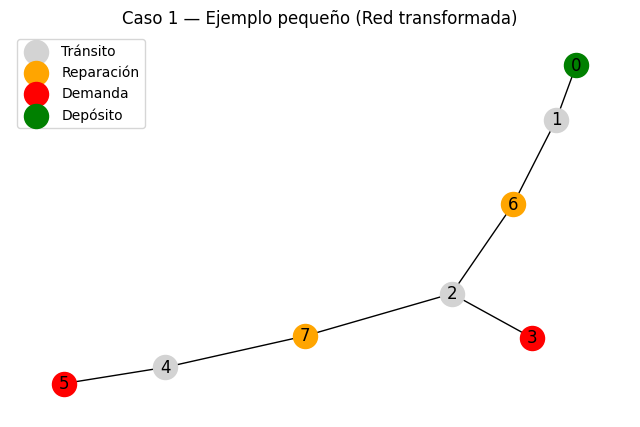

In [25]:
pos1 = draw_graph(
    data,
    title="Caso 1 — Ejemplo pequeño (Red transformada)",
    savepath=str(OUT/"figures"/"case1_graph.png")
)

In [26]:
two = solve_two_stage_exact(data)
print("Caso MILP en dos etapas (Two-stage exact solver IOSRCRVD)")
print("Cuadrilla de reparación", format_route_with_done_times(two["rep"], two["d"]))
print("Vehículo de ayuda", format_dem_with_service_end(data, two["dem"], two["d"]))
print("f' =", int(round(two["fprime"])))

Caso MILP en dos etapas (Two-stage exact solver IOSRCRVD)
Cuadrilla de reparación 0(0)-6(12)-7(21)
Vehículo de ayuda 0(0)-3(21)-5(34)
f' = 34


In [27]:
integ = solve_integrated_exact(data)
print("Caso IOSRCRVD integrado (Integrated exact solver)")
print("Cuadrilla de reparación", format_route_with_done_times(integ["rep"], integ["d"]))
print("Vehículo de ayuda", format_dem_with_service_end(data, integ["dem"], integ["d"]))
print("f' =", int(round(integ["fprime"])))

Caso IOSRCRVD integrado (Integrated exact solver)
Cuadrilla de reparación 0(0)-6(12)-7(21)
Vehículo de ayuda 0(0)-3(21)-5(34)
f' = 34


In [28]:
aco = IOSRCRVD_ACO(data, params)
best = aco.solve()

print("=== CASO 1 ===")
print("Ruta reparación:", best.repair_route)
print("d_i:", {k: round(best.repair_done_time[k], 2) for k in sorted(best.repair_done_time)})
print("Ruta ayuda:", best.relief_route)
print("Objetivo:", round(best.objective, 2))

=== CASO 1 ===
Ruta reparación: [0, 6, 7]
d_i: {6: 12.0, 7: 21.0}
Ruta ayuda: [0, 3, 5]
Objetivo: 34.0


In [29]:
print("--- Traza ayuda (Caso 1) ---")
for a, b, ts, ta, sv, tf in trace_relief(data, best):
    print(f"{a}->{b}: sale {ts:.2f}, llega {ta:.2f}, servicio {sv:.2f}, termina {tf:.2f}")

df_rep, df_rel = results_tables(data, best)
display(df_rep)
display(df_rel)

--- Traza ayuda (Caso 1) ---
0->3: sale 0.00, llega 17.00, servicio 4.00, termina 21.00
3->5: sale 21.00, llega 31.00, servicio 3.00, termina 34.00


,repair_node,repair_finish
0,6,12.0
1,7,21.0


,from,to,t_depart,t_arrive,service,t_finish
0,0,3,0.0,17.0,4.0,21.0
1,3,5,21.0,31.0,3.0,34.0


### **Interpretación de la solución obtenida**

La ejecución del algoritmo devuelve dos rutas coordinadas: una para el **equipo de reparación** y otra para el **vehículo de ayuda**. La función objetivo es el **instante en el que termina el último servicio de ayuda**; en este ejemplo el objetivo final es **$34.0$**.

#### **Ruta del equipo de reparación**
La ruta de reparación obtenida es: $[0, 6, 7]$. Esto indica que el equipo sale del depósito (nodo $0$), repara primero el nodo $6$ y después el nodo $7$. Con los tiempos de viaje y las duraciones de reparación $s_i$, se calculan los instantes de finalización $d_i$: $d_6 = 12.0$ y $d_7 = 21.0$. En el tiempo $12.0$ el nodo $6$ ya está reparado.
En el tiempo $21.0$ el nodo $7$ ya está reparado.

> Interpretación práctica: $d_i$ representa el tiempo a partir del cual el nodo de reparación $i$ queda completamente operativo. Por tanto:

Estos valores son fundamentales porque determinan **si el vehículo de ayuda puede atravesar dichos nodos sin esperar**. En términos operativos, esta ruta define el calendario de “reapertura” progresiva de la red.

#### **Ruta del vehículo de ayuda: Llegadas, servicio y objetivo**

La ruta de ayuda obtenida es: $[0, 3, 5]$. Esto se interpreta así:

1. **Desplazamiento hacia el nodo $3$:** El vehículo sale en $t = 0.00$ y llega al nodo $3$ en $t = 17.00$. Este valor corresponde al **tiempo de llegada más temprano**, que incluye automáticamente cualquier posible espera causada por atravesar nodos de reparación aún no disponibles (si aplica en el recorrido óptimo).

2. **Servicio en el nodo $3$:** El tiempo de servicio en $3$ es $s'_3 = 4.0$. Por tanto, el vehículo termina en $17.00 + 4.00 = 21.00$

3. **Desplazamiento hacia el nodo $5$:** Se parte en $t = 21.00$ y se llega al nodo $5$ en $t = 31.00$.

4. **Servicio en el nodo $5$ y finalización:** El tiempo de servicio en $5$ es $s'_5 = 3.0$. El instante final queda: $$31.00 + 3.00 = 34.00$$

Por definición, este último instante corresponde a la función objetivo:
$$\text{Objetivo} = 34.0$$

#### **Lectura global de la solución**

El resultado muestra claramente la lógica integrada del problema:

- La ruta de reparación determina los tiempos $d_i$ (cuándo la red se vuelve utilizable en los nodos dañados).
- La ruta de ayuda se calcula respetando dichas disponibilidades, incorporando esperas cuando sea necesario.
- La función objetivo $34.0$ mide el desempeño global del operativo: viajes, posibles esperas y servicio, hasta completar el último punto de demanda.

En un contexto aplicado, $34.0$ puede interpretarse como el **tiempo total de respuesta** requerido para completar toda la operación de ayuda bajo restricciones de reparación.

## **Caso 2: Instancia del artículo**

En este segundo caso de estudio se considera la instancia propuesta en el artículo original. A diferencia del ejemplo ilustrativo anterior, este escenario presenta una red más compleja, con un mayor número de nodos de reparación y una estructura de conectividad más rica, lo que permite evaluar el comportamiento del algoritmo en una situación más realista.

El escenario se modela mediante un grafo no dirigido cuyos arcos representan los tiempos de desplazamiento entre ubicaciones. Todas las operaciones parten de un nodo depósito común, identificado como el nodo $0$, que actúa como origen tanto para el equipo de reparación como para el vehículo de ayuda humanitaria.

En esta instancia se consideran seis nodos de reparación, $\{2,3,5,7,9,10\}$, cada uno con un tiempo de reparación $s_i$ distinto. Estos valores reflejan diferentes niveles de daño en la infraestructura y determinan el orden y el impacto temporal de las reparaciones sobre la accesibilidad de la red. La finalización de estas reparaciones define de manera progresiva la disponibilidad de determinados caminos.

Por su parte, los nodos de demanda son $\{1,4,6\}$, todos ellos con un tiempo de servicio uniforme $s'_i = 2$. Estos nodos representan ubicaciones que requieren atención humanitaria una vez que las rutas necesarias para acceder a ellas se encuentran operativas.

La característica más relevante de este escenario es la fuerte dependencia entre ambos tipos de nodos. Muchos de los caminos que conectan el depósito con los nodos de demanda atraviesan nodos de reparación, lo que implica que el vehículo de ayuda puede verse obligado a esperar hasta que ciertas reparaciones hayan finalizado. Esta interacción hace que la planificación conjunta de ambas rutas sea esencial para minimizar el tiempo total de respuesta.

In [30]:
def build_example_paper() -> ProblemData:
    adj = {}
    add_undirected_edge(adj, 0, 3, 5)
    add_undirected_edge(adj, 0, 8, 10)
    add_undirected_edge(adj, 0, 2, 6)
    add_undirected_edge(adj, 3, 4, 5)
    add_undirected_edge(adj, 4, 9, 8)
    add_undirected_edge(adj, 9, 8, 1)
    add_undirected_edge(adj, 8, 7, 5)
    add_undirected_edge(adj, 7, 6, 6)
    add_undirected_edge(adj, 6, 10, 3)
    add_undirected_edge(adj, 6, 5, 2)
    add_undirected_edge(adj, 5, 1, 2)
    add_undirected_edge(adj, 1, 2, 5)
    add_undirected_edge(adj, 2, 6, 7)

    return ProblemData(
        adj=adj,
        depot=0,
        repair_nodes={2, 3, 5, 7, 9, 10},
        demand_nodes={1, 4, 6},
        repair_time={2: 6, 3: 5, 5: 3, 7: 14, 9: 7, 10: 16},
        demand_service_time={1: 2, 4: 2, 6: 2},
    )

In [31]:
data = build_example_paper()
params = ACOParams()

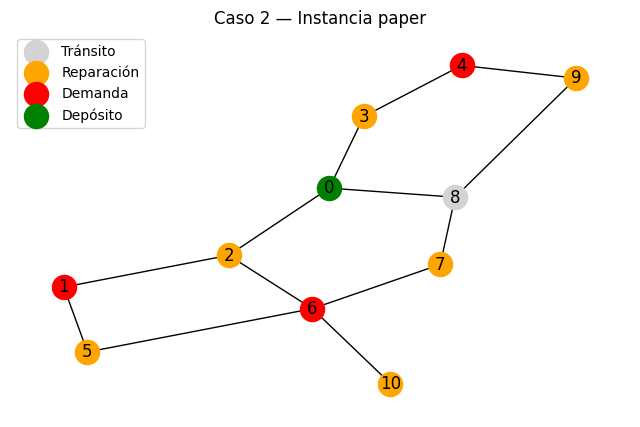

In [32]:
pos2 = draw_graph(
    data,
    title="Caso 2 — Instancia paper",
    savepath=str(OUT/"figures"/"case2_graph.png")
)

In [33]:
two = solve_two_stage_exact(data)
print("Caso MILP en dos etapas (Two-stage exact solver IOSRCRVD)")
print("Cuadrilla de reparación", format_route_with_done_times(two["rep"], two["d"]))
print("Vehículo de ayuda", format_dem_with_service_end(data, two["dem"], two["d"]))
print("f' =", int(round(two["fprime"])))

Caso MILP en dos etapas (Two-stage exact solver IOSRCRVD)
Cuadrilla de reparación 0(0)-2(12)-3(28)-5(49)-7(71)-9(84)-10(115)
Vehículo de ayuda 0(0)-1(19)-6(33)-4(58)
f' = 58


In [34]:
integ = solve_integrated_exact(data)
print("Caso IOSRCRVD integrado (Integrated exact solver)")
print("Cuadrilla de reparación", format_route_with_done_times(integ["rep"], integ["d"]))
print("Vehículo de ayuda", format_dem_with_service_end(data, integ["dem"], integ["d"]))
print("f' =", int(round(integ["fprime"])))

Caso IOSRCRVD integrado (Integrated exact solver)
Cuadrilla de reparación 0(0)-3(10)-2(27)-5(37)-7(59)-9(72)-10(103)
Vehículo de ayuda 0(0)-4(17)-1(40)-6(46)
f' = 46


In [35]:
aco = IOSRCRVD_ACO(data, params)
best = aco.solve()

print("Caso ACO")
print("Ruta reparación:", best.repair_route)
print("d_i:", {k: round(best.repair_done_time[k], 2) for k in sorted(best.repair_done_time)})
print("Ruta ayuda:", best.relief_route)
print("Objetivo:", round(best.objective, 2))

Caso ACO
Ruta reparación: [0, 3, 2, 5, 7, 9, 10]
d_i: {2: 27.0, 3: 10.0, 5: 37.0, 7: 59.0, 9: 72.0, 10: 103.0}
Ruta ayuda: [0, 4, 1, 6]
Objetivo: 46.0


In [36]:
print("--- Traza ayuda (Caso 2) ---")
for a, b, ts, ta, sv, tf in trace_relief(data, best):
    print(f"{a}->{b}: sale {ts:.2f}, llega {ta:.2f}, servicio {sv:.2f}, termina {tf:.2f}")

df_rep, df_rel, = results_tables(data, best)
display(df_rep)
display(df_rel)

--- Traza ayuda (Caso 2) ---
0->4: sale 0.00, llega 15.00, servicio 2.00, termina 17.00
4->1: sale 17.00, llega 38.00, servicio 2.00, termina 40.00
1->6: sale 40.00, llega 44.00, servicio 2.00, termina 46.00


,repair_node,repair_finish
0,3,10.0
1,2,27.0
2,5,37.0
3,7,59.0
4,9,72.0
5,10,103.0


,from,to,t_depart,t_arrive,service,t_finish
0,0,4,0.0,15.0,2,17.0
1,4,1,17.0,38.0,2,40.0
2,1,6,40.0,44.0,2,46.0


### **Interpretación de la solución obtenida**

La ejecución del algoritmo ACO sobre esta instancia produce una solución compuesta por dos rutas coordinadas y un valor de la función objetivo igual a **$46.0$**, que representa el instante en el que se completa el último servicio de ayuda.

#### **Ruta del equipo de reparación**
La ruta obtenida para el equipo de reparación es: $[0, 3, 2, 5, 7, 9, 10]$. A partir de esta ruta se calculan los instantes de finalización de las reparaciones $d_i$: $d_3 = 10.0$, $d_2 = 27.0$, $d_5 = 37.0$, $d_7 = 59.0$, $d_9 = 72.0$ y $d_{10} = 103.0$. Cada valor $d_i$ indica el momento a partir del cual el nodo de reparación correspondiente queda completamente operativo. Estos tiempos determinan la evolución temporal de la red y condicionan directamente las decisiones del vehículo de ayuda.

#### **Ruta del vehículo de ayuda: Llegadas, servicio y objetivo**
La ruta obtenida para el vehículo de ayuda es: $[0, 4, 1, 6]$. La traza temporal asociada a esta ruta es la siguiente: El vehículo de ayuda alcanza el nodo $4$ en el tiempo $15.00$ y completa el servicio en $17.00$. Posteriormente se desplaza al nodo $1$, al que llega en el tiempo $38.00$. Este valor de llegada incorpora de manera implícita posibles esperas causadas por reparaciones aún no finalizadas en los nodos intermedios del camino óptimo. Tras completar el servicio en el nodo $1$, el vehículo se dirige al nodo $6$, finalizando el último servicio en el tiempo $46.00$.

Por definición, este instante corresponde a la función objetivo:
$$
\text{Objetivo} = 46.0
$$

#### **Lectura global de la solución**

Desde una perspectiva global, la solución muestra cómo el algoritmo coordina la secuencia de reparaciones con la planificación de la distribución de ayuda. La ruta de reparación determina la disponibilidad progresiva de la red a través de los valores $d_i$, mientras que la ruta de ayuda se adapta a dicha disponibilidad, incorporando esperas cuando es necesario. El valor final de $46.0$ puede interpretarse como el tiempo total de respuesta del sistema para este escenario, proporcionando una medida clara del desempeño operativo de la solución obtenida.